In [1]:
import pandas as pd 
import janitor

def get_data():
    URL_CSV="https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
    df = pd.read_csv(URL_CSV)
    df['Country/Region'] = df['Country/Region'].replace({'US':'United States of America'})
    return df
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,49579,49989,50442,50952,51528,51948,52571,53075,53520,54060
264,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
265,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2060,2060,2060,2060,2060,2061,2062,2062,2063,2063
266,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,16095,16117,16117,16200,16243,16285,16325,16415,16432,16480


INFO:numexpr.utils:NumExpr defaulting to 8 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
2,2020-01-24,-8.043175e+03,0.000000e+00,3.213918e+05,-8.043175e+03,-8.043175e+03,27166.475077,27166.475077,27166.475077,27166.475077,27166.475077,27166.475077,0.0,0.0,0.0,1.912330e+04
3,2020-01-25,-5.149021e+03,0.000000e+00,3.549733e+05,-5.149021e+03,-5.149021e+03,33376.541602,33376.541602,33376.541602,33376.541602,33376.541602,33376.541602,0.0,0.0,0.0,2.822752e+04
4,2020-01-26,-2.254867e+03,0.000000e+00,3.379861e+05,-2.254867e+03,-2.254867e+03,14452.922447,14452.922447,14452.922447,14452.922447,14452.922447,14452.922447,0.0,0.0,0.0,1.219806e+04
8,2020-01-30,9.321749e+03,0.000000e+00,3.256854e+05,9.321749e+03,9.321749e+03,3211.776341,3211.776341,3211.776341,3211.776341,3211.776341,3211.776341,0.0,0.0,0.0,1.253352e+04
9,2020-01-31,1.221590e+04,0.000000e+00,3.558474e+05,1.221590e+04,1.221590e+04,27166.475077,27166.475077,27166.475077,27166.475077,27166.475077,27166.475077,0.0,0.0,0.0,3.938238e+04
10,2020-02-01,1.511008e+04,0.000000e+00,3.795120e+05,1.511008e+04,1.511008e+04,33376.541602,33376.541602,33376.541602,33376.541602,33376.541602,33376.541602,0.0,0.0,0.0,4.848662e+04
11,2020-02-02,1.800426e+04,0.000000e+00,3.509730e+05,1.800426e+04,1.800426e+04,14452.922447,14452.922447,14452.922447,14452.922447,14452.922447,14452.922447,0.0,0.0,0.0,3.245718e+04
14,2020-02-05,2.668680e+04,0.000000e+00,3.239517e+05,2.668680e+04,2.668680e+04,-16912.717676,-16912.717676,-16912.717676,-16912.717676,-16912.717676,-16912.717676,0.0,0.0,0.0,9.774083e+03
15,2020-02-06,2.958098e+04,0.000000e+00,3.639228e+05,2.958098e+04,2.958098e+04,3211.776341,3211.776341,3211.776341,3211.776341,3211.776341,3211.776341,0.0,0.0,0.0,3.279276e+04
16,2020-02-07,3.247516e+04,0.000000e+00,3.624781e+05,3.247516e+04,3.247516e+04,27166.475077,27166.475077,27166.475077,27166.475077,27166.475077,27166.475077,0.0,0.0,0.0,5.964163e+04


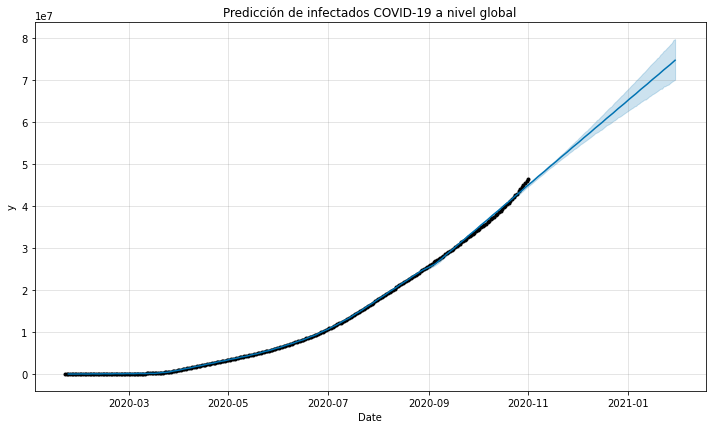

In [2]:
import janitor
import pandas as pd
import pandas_flavor as pf
import fbprophet
from matplotlib import pyplot as plt    
from IPython.display import display, HTML



LISTA_COLUMNAS_A_BORRAR = ['Province/State', 'Country/Region', 'Lat', 'Long']



df = get_data()
df = df.remove_columns(LISTA_COLUMNAS_A_BORRAR)
df
df = pd.DataFrame( df.sum())
df.columns=['y']
df.index = pd.to_datetime(df.index)  
df['ds'] = df.index
df = df.reset_index()


df = df.remove_columns(['index'])


df_prophet = fbprophet.Prophet(changepoint_prior_scale=0.15)
df_prophet.fit(df)

df_forecast = df_prophet.make_future_dataframe(periods=90, freq='D')
# Make predictions
df_forecast = df_prophet.predict(df_forecast)
df_forecast

df_forecast = df_forecast[df_forecast["yhat"] >= 0]
df_forecast.loc[df_forecast.yhat_lower < 0, 'yhat_lower'] = 0


df_prophet.plot(df_forecast, xlabel = 'Date' )
plt.title('Predicción de infectados COVID-19 a nivel global'   )

display(HTML(pd.DataFrame(df_forecast).to_html()))


In [3]:
df = get_data()
df

,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,10/23/20,10/24/20,10/25/20,10/26/20,10/27/20,10/28/20,10/29/20,10/30/20,10/31/20,11/1/20
0,NaN,Afghanistan,33.939110,67.709953,0,0,0,0,0,0,...,40687,40768,40833,40937,41032,41145,41268,41334,41425,41501
1,NaN,Albania,41.153300,20.168300,0,0,0,0,0,0,...,18556,18858,19157,19445,19729,20040,20315,20634,20875,21202
2,NaN,Algeria,28.033900,1.659600,0,0,0,0,0,0,...,55630,55880,56143,56419,56706,57026,57332,57651,57942,58272
3,NaN,Andorra,42.506300,1.521800,0,0,0,0,0,0,...,4038,4038,4038,4325,4410,4517,4567,4665,4756,4825
4,NaN,Angola,-11.202700,17.873900,0,0,0,0,0,0,...,8829,9026,9381,9644,9871,10074,10269,10558,10805,11035
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263,NaN,West Bank and Gaza,31.952200,35.233200,0,0,0,0,0,0,...,49579,49989,50442,50952,51528,51948,52571,53075,53520,54060
264,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,10,10,10,10,10,10,10,10,10,10
265,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,2060,2060,2060,2060,2060,2061,2062,2062,2063,2063
266,NaN,Zambia,-13.133897,27.849332,0,0,0,0,0,0,...,16095,16117,16117,16200,16243,16285,16325,16415,16432,16480


In [4]:

import janitor
import datetime
import numpy as np

def pipeline_populations():
    """ Cogemos un dataframe de poblaciones"""

    URL="https://population.un.org/wpp/Download/Files/1_Indicators%20(Standard)/CSV_FILES/WPP2019_TotalPopulationBySex.csv"
    THIS_YEAR = datetime.datetime.now().year

    return (
        pd.read_csv(URL)
        .filter_on( f""" Time  ==  {THIS_YEAR} & Variant == "Medium" """ ) 
        .select_columns(['Location','PopTotal'])
        .join_apply(lambda x: x['PopTotal'] * 1000 , new_column_name="PopMillions" )
        .remove_columns(['PopTotal'])
        .rename_column('PopMillions' , 'PopTotal')
        .transform_column('PopTotal',np.int64)
        .rename_column('Location' , 'Country/Region')
    )


populations = pipeline_populations()
populations

,Country/Region,PopTotal
70,Afghanistan,38928341
954,Africa,1340598113
1838,African Group,1338826591
1989,African Union,1339423920
2140,African Union: Central Africa,158619638
...,...,...
277315,World,7794798728
278199,World Bank Regional Groups (developing only),6528762227
278350,Yemen,29825967
279234,Zambia,18383956


In [5]:
df = get_data()
df_country = pd.DataFrame()
df_country['Country/Region'] = df['Country/Region']
df_country['infected last_day'] = df.iloc[:,-1] - df.iloc[:,-2]
df_country.set_index('Country/Region')
df_country

,Country/Region,infected last_day
0,Afghanistan,76
1,Albania,327
2,Algeria,330
3,Andorra,69
4,Angola,230
...,...,...
263,West Bank and Gaza,540
264,Western Sahara,0
265,Yemen,0
266,Zambia,48


In [6]:
df_country_enrich = pd.merge(df_country, populations, on="Country/Region")
df_country_enrich['Infected/Million'] =  1000000 * df_country_enrich['infected last_day'] / df_country_enrich['PopTotal'] 
df_country = df_country_enrich

In [7]:
df_country.sort_values(by='Infected/Million', ascending=False).head(10)

,Country/Region,infected last_day,PopTotal,Infected/Million
23,Belgium,11789,11589616,1017.203676
3,Andorra,69,77265,893.030480
7,Armenia,2441,2963234,823.762146
119,France,46290,65273512,709.169747
209,Slovenia,1342,2078932,645.523759
92,Czechia,6542,10708982,610.889065
169,Montenegro,373,628062,593.890412
16,Austria,4956,9006400,550.275360
89,Croatia,2179,4105268,530.781425
178,Netherlands,8683,17134873,506.744345


In [8]:
from datetime import datetime, timedelta
import seaborn as sns
from matplotlib import pyplot as plt
import matplotlib.dates as mdates


def pintar_grafico(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    df = df.iloc[:, : 9]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    chart_df.plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    #df.tail(30).style.format ({ c : "{:20,.0f}" for c in df.columns }).background_gradient(cmap='Wistia', )
    return plt 



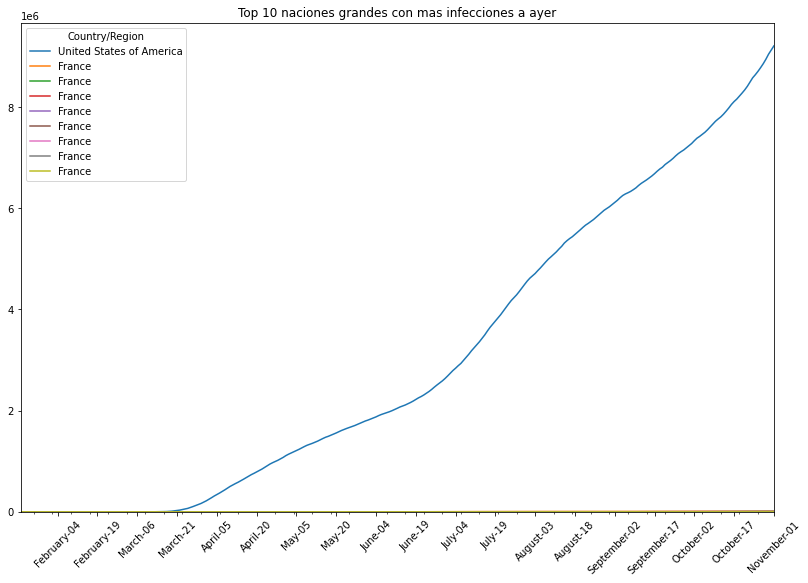

<module 'matplotlib.pyplot' from '/root/anaconda2/envs/jupyter/lib/python3.6/site-packages/matplotlib/pyplot.py'>

In [9]:
title="Top 10 naciones grandes con mas infecciones a ayer"
display(HTML(f"""<h1 id='{title}'>{title}</h1>"""))
df = get_data()

naciones_pintar = df_country.sort_values(by='infected last_day', ascending=False).head(10)['Country/Region'].values
df_country.sort_values(by='infected last_day', ascending=False).head(10)

pintar_grafico(df,naciones_pintar,title)



In [10]:
def pintar_grafico_daily(df, array_naciones_pintar ,title):
    df = df.T
    df = df.iloc[1:]
    new_header = df.iloc[0] #grab the first row for the header
    df = df[1:] #take the data less the header row
    df.columns = new_header #set the header row as the df header
    df = df.iloc[2:]
    df.index = pd.to_datetime(df.index)
    df = df[array_naciones_pintar]
    chart_df = df

    pd.plotting.register_matplotlib_converters()
    
    df_daily_increments = pd.DataFrame()
    for country in chart_df.columns:
        df_daily_increments[country] = chart_df[country].pct_change().rolling(window=7).mean()

    df_daily_increments    

    chart_df = df_daily_increments
    chart_df.tail(45).plot(legend=True,figsize=(13.5,9))

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%B-%d'))
    plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=15))
    plt.xticks(rotation=45)

    ax = plt.gca()

    ax.set_title(title)
    ax.set_ylim(ymin=0)

    plt.show()

    chart_df.tail(30).style.format ({ c : "{:20,.2f}" for c in df.columns }).background_gradient(cmap='Wistia', )


    return chart_df


#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")
df_country

,Country/Region,infected last_day,PopTotal,Infected/Million
0,Afghanistan,76,38928341,1.952305
1,Albania,327,2877800,113.628466
2,Algeria,330,43851043,7.525477
3,Andorra,69,77265,893.030480
4,Angola,230,32866267,6.998057
...,...,...,...,...
243,Uzbekistan,224,33469199,6.692721
244,Western Sahara,0,597330,0.000000
245,Yemen,0,29825967,0.000000
246,Zambia,48,18383956,2.610972


In [11]:
#pintar_grafico_daily(df,naciones_pintar,"Top 10 countries more cases, daily percentage change")